In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [39]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  payer_type      object 
dtypes: float64(5), int64(3), object(4)
memory usage: 582.5+ MB


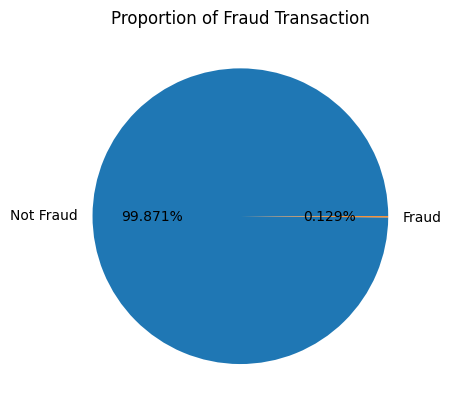

In [47]:
plt.pie(df["isFraud"].value_counts(),labels=['Not Fraud','Fraud'],autopct='%1.3f%%')
plt.title('Proportion of Fraud Transaction')
plt.show()

In [48]:
df["isFraud"].value_counts()

,count
isFraud,
0,6354407
1,8213


In [49]:
df["payerdebited"]=df["oldbalanceOrg"]-df["newbalanceOrig"]
df["payerdebited"].describe()

,payerdebited
count,6.362620e+06
mean,-2.123056e+04
std,1.466433e+05
min,-1.915268e+06
25%,0.000000e+00
50%,0.000000e+00
75%,1.015044e+04
max,1.000000e+07


In [50]:
df["recievercredited"]=df["newbalanceDest"]-df["oldbalanceDest"]
df["recievercredited"].describe()

,recievercredited
count,6.362620e+06
mean,1.242947e+05
std,8.129391e+05
min,-1.306083e+07
25%,0.000000e+00
50%,0.000000e+00
75%,1.491054e+05
max,1.056878e+08


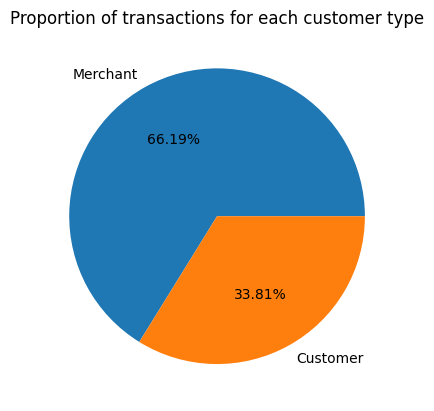

In [51]:
df["reciever_type"]=[i[0:1] for i in df["nameDest"]] # is the reciever a merchant (M) or customer (C)?
plt.pie(df["reciever_type"].value_counts(), labels=["Merchant","Customer"],autopct='%1.2f%%')
plt.title("Proportion of transactions for each customer type")
plt.show()

In [52]:
df["payer_type"]=[i[0:1] for i in df["nameOrig"]] # is the reciever a merchant (M) or customer (C)?
df['payer_type'].value_counts()# entropy is 0

,count
payer_type,
C,6362620


In [53]:
#To make the features related to the real world, lets assume that the dataset belongs to April, 2025
#as the financial year begins with April and it is exactly 30 days long.
df['datetime'] = pd.to_datetime('2025-04-01') + pd.to_timedelta(df['step'], unit='h')
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['date'] = df['datetime'].dt.day
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,payer_type,payerdebited,recievercredited,reciever_type,datetime,hour,day_of_week,date
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,C,9839.64,0.0,M,2025-04-01 01:00:00,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,C,1864.28,0.0,M,2025-04-01 01:00:00,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,C,181.00,0.0,C,2025-04-01 01:00:00,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,C,181.00,-21182.0,C,2025-04-01 01:00:00,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,C,11668.14,0.0,M,2025-04-01 01:00:00,1,1,1


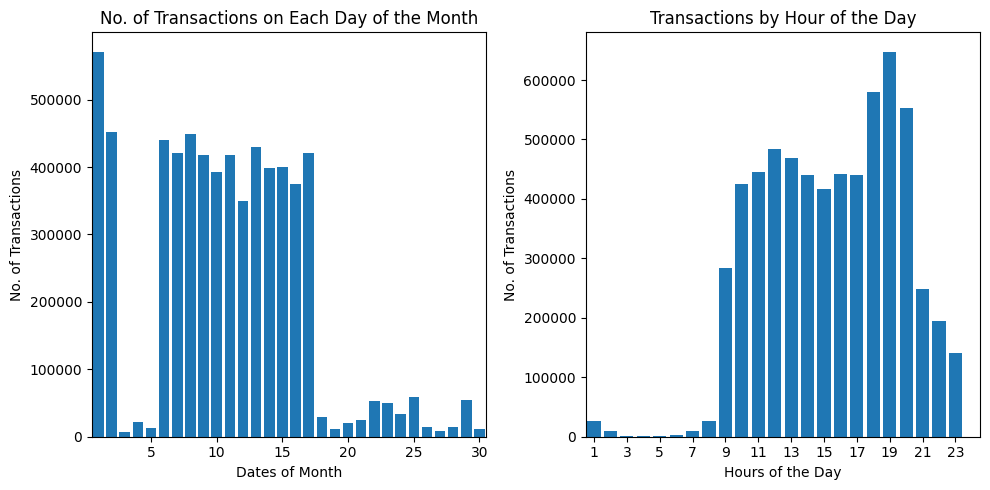

In [57]:
plt.figure(figsize=(10,5)),

# --- Subplot 1: Transactions by Date ---
plt.subplot(121)
date_counts = df['date'].value_counts().sort_index()  # Sorts by actual date order
plt.bar(date_counts.index, date_counts.values)
plt.xlim(0.5, 30.5)
plt.xlabel("Dates of Month")
plt.ylabel("No. of Transactions")
plt.title("No. of Transactions on Each Day of the Month")


# --- Subplot 3: Transactions by Hour ---
plt.subplot(122)
hour_counts = df['hour'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values)
plt.xlim(0.5, 24.5)
plt.xticks(range(1, 25, 2))
plt.xlabel("Hours of the Day")
plt.ylabel("No. of Transactions")
plt.title("Transactions by Hour of the Day")

plt.tight_layout()
plt.show()


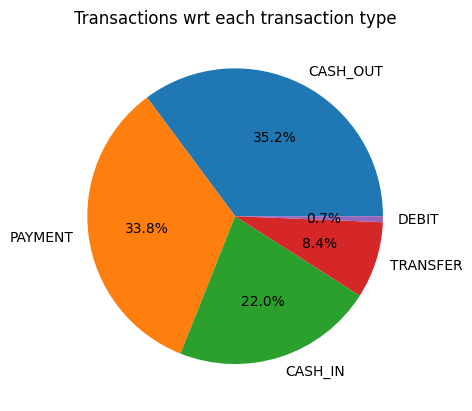

In [55]:
plt.pie(df["type"].value_counts(), labels=df["type"].value_counts().index,autopct='%1.1f%%')
plt.title("Transactions wrt each transaction type")
plt.show()

In [58]:
todrop=["nameDest",
"nameOrig",
"oldbalanceOrg",
"newbalanceOrig",
"newbalanceDest",
"oldbalanceDest",
"payer_type", #this is a zero variance feature
"step", #extracted hour,date and day_of_week
"datetime",
"isFlaggedFraud",
"recievercredited"]
df.drop(columns=todrop, inplace=True)

In [59]:
#Label Encoding of Categorical columns
cat_cols=[col for col in df.columns if df[col].dtype=="object"]
encoder=LabelEncoder()
encoded_df=df.copy()
mappings={}
for col in cat_cols:
    encoded_df[col]=encoder.fit_transform(df[col])
    mappings[col]=pd.Series(encoder.transform(encoder.classes_),index=(encoder.classes_))

In [16]:
mappings

{'type': CASH_IN     0
 CASH_OUT    1
 DEBIT       2
 PAYMENT     3
 TRANSFER    4
 dtype: int64,
 'reciever_type': C    0
 M    1
 dtype: int64}

In [17]:
#Since an attempt to transfer more than 200,000 in a single transaction is an illegal attempt, we
#modify the target variable accordingly
df_new = encoded_df.copy()
y = pd.Series([
1 if encoded_df.loc[i, "amount"] > 200000 else encoded_df.loc[i, "isFraud"] for i in
range(len(encoded_df))
])
df_new['isFraud'] = y

Combining illegal and fraud transaction together
===

In [18]:
df_fraud=df_new[df_new["isFraud"]==1]
df_not_fraud=df_new[df_new["isFraud"]==0]
df_fraud.shape,df_not_fraud.shape

((1676312, 8), (4686308, 8))

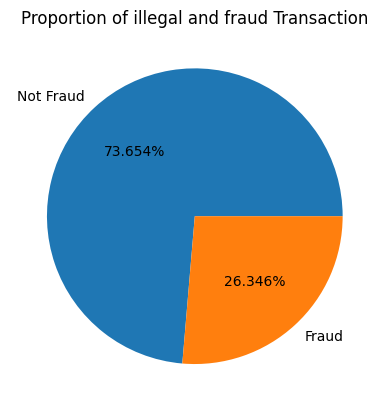

In [19]:
plt.pie(df_new["isFraud"].value_counts(),labels=['Not Fraud','Fraud'],autopct='%1.3f%%')
plt.title('Proportion of illegal and fraud Transaction')
plt.show()

SAMPLING
===

UNDER
---

In [20]:
df_not_fraud_under = df_not_fraud.sample(df_fraud.shape[0])
print(df_not_fraud_under.shape,df_fraud.shape)
df_under = pd.concat([df_not_fraud_under,df_fraud])
df_under.shape

(1676312, 8) (1676312, 8)


(3352624, 8)

In [21]:
x_under = df_under.drop(columns="isFraud")
y_under = df_under["isFraud"]
x_train_under,x_test_under,y_train_under,y_test_under=train_test_split(x_under,y_under,test_size=0.2,random_state=42,stratify=df_under["isFraud"])

OVER
---

In [22]:
df_fraud_over = df_fraud.sample(df_not_fraud.shape[0], replace=True)
print(df_fraud_over.shape,df_not_fraud.shape)
df_over = pd.concat([df_fraud_over,df_not_fraud])
df_over.shape

(4686308, 8) (4686308, 8)


(9372616, 8)

In [23]:
x_over = df_over.drop(columns="isFraud")
y_over = df_over["isFraud"]
x_train_over,x_test_over,y_train_over,y_test_over=train_test_split(x_over,y_over,test_size=0.2,random_state=42,stratify=df_over["isFraud"])

SMOTE
---

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
x = df_new.drop(columns="isFraud")
y = df_new["isFraud"]
X_sm ,y_sm = smote.fit_resample(x,y)
y_sm.value_counts(),X_sm.shape


(isFraud
 0    4686308
 1    4686308
 Name: count, dtype: int64,
 (9372616, 7))

In [25]:
x_train_sm,x_test_sm,y_train_sm,y_test_sm=train_test_split(X_sm,y_sm,test_size=0.2,random_state=42,stratify=y_sm)
y_train_sm.value_counts()

,count
isFraud,
1,3749046
0,3749046


# Gini Index

In [26]:
#UNDER
model = DecisionTreeClassifier(criterion = 'gini')
model.fit(x_train_under,y_train_under)
model.score(x_test_under,y_test_under)*100

99.90589463480109

In [27]:
#OVER
model = DecisionTreeClassifier(criterion = 'gini')
model.fit(x_train_over,y_train_over)
model.score(x_test_over,y_test_over)*100

99.97316652120752

In [28]:
#SMOTE
model_gsm = DecisionTreeClassifier(criterion = 'gini')
model_gsm.fit(x_train_sm,y_train_sm)
model_gsm.score(x_test_sm,y_test_sm)*100

99.94521275801218

# Entropy

In [29]:
#UNDER
model_eu = DecisionTreeClassifier(criterion = 'entropy')
model_eu.fit(x_train_under,y_train_under)
model_eu.score(x_test_under,y_test_under)*100

99.9106670146527

In [30]:
#OVER
model_eo = DecisionTreeClassifier(criterion = 'entropy')
model_eo.fit(x_train_over,y_train_over)
model_eo.score(x_test_over,y_test_over)*100

99.9750870087553

In [31]:
#SMOTE
model_esm = DecisionTreeClassifier(criterion = 'entropy')
model_esm.fit(x_train_sm,y_train_sm)
model_esm.score(x_test_sm,y_test_sm)*100

99.95134764878976

In [32]:
y_pred_eo = model_eo.predict(x_test_over)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test_over,y_pred_eo))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    937262
           1       1.00      1.00      1.00    937262

    accuracy                           1.00   1874524
   macro avg       1.00      1.00      1.00   1874524
weighted avg       1.00      1.00      1.00   1874524



Text(50.722222222222214, 0.5, 'Actual')

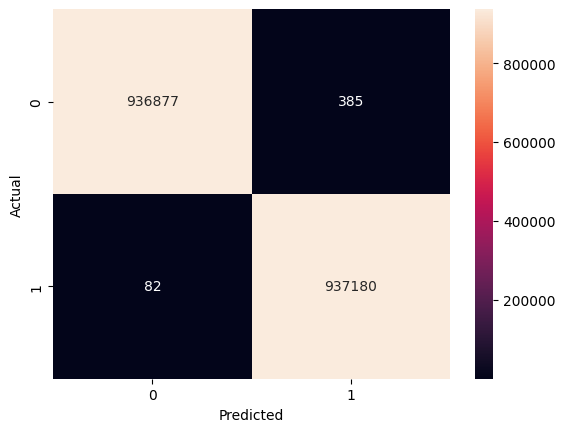

In [35]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test_over,y_pred_eo)
sns.heatmap(cf,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [36]:
random_sample = np.array([3,32340, 18000.00, 1, 16, 3, 7])
random_sample = random_sample.reshape(1, -1)
pred = model_eo.predict(random_sample)
if(pred == 1):
  print('Its a Fraud')
else:
  print('Its not a Fraud')

Its not a Fraud


In [61]:
x_train_over.columns

Index(['type', 'amount', 'payerdebited', 'reciever_type', 'hour',
       'day_of_week', 'date'],
      dtype='object')